In [1]:
%%html
<style type='text/css'>
  .rendered_html {
      font-family: Courier New;
      font-size:110%;
      line-height:115%;
  }
  .rendered_html code {
      font-size: 90%;
  }
</style>

In [2]:
import fastbook
# looking at the source code of this, it looks as though this is only necessary when
# running in Google Collab(?)
fastbook.setup_book()

# Chapter 2 - FastAI 2020

In this chapter we'll build an image classifier using data scraped from the Internet. Specifically, we'll download a couple hundred pictures of a few kinds of bears and leverage **transfer learning** to build a very good classifier.

In [3]:
# not the best practice in production, due to potential silent shadowing, which can 
# lead to subtle bugs
from fastbook import *
from fastai.vision.all import *

# 1. A Bears Classifier

## 1.1. Scraping Images from the Internet

Creating your own scraper to get images from the internet is not hard, but the purpose of this chapter is to focus on how to build image classifiers, so we'll just use a ready-made function `search_images_bing` which queries the Bing search engine.

To use it, you'll need to have an Azure account and get an API key for their search service:

In [4]:
import os
# TODO: do not leave this key on public repositories
SEARCH_API_KEY = os.environ.get('AZURE_SEARCH_KEY', 'c15840f3339a48cfb0944dfb50eee2f5')

In [5]:
results = search_images_bing(SEARCH_API_KEY, 'grizzly bear')
# results is of type fastcore.foundation.L, a thin wrapper on top of Python's list
# which provides several convenience methods, one of them is `attrgot` which scans
# a list and access the specified attribute on each object (it assumes each item is
# an object or dictionary)
images = results.attrgot('contentUrl')

In [6]:
len(images), images[0]

(150,
 'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg')

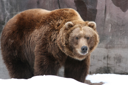

In [7]:
destination = 'images/grizzly.jpg'
download_url(images[0], destination)
img = Image.open(destination)
img.to_thumb(128, 128)

## 1.2 Data Cleanup
We can never assume that the data we are given will be valid or be in the right format for our deep learning models. As a matter of fact, we should assume the opposite and always validate it before feeding it into our models.

In [8]:
import shutil

def fetch_images(path, thing, kinds, force=False):
    if path.exists() and not force:
        # previously downloaded so nothing to do...
        return

    shutil.rmtree(path, ignore_errors=True)
    path.mkdir()
    for kind in kinds:
        destination = path/kind
        destination.mkdir(exist_ok=True)
        results = search_images_bing(SEARCH_API_KEY, f'{kind} {thing}')
        download_images(destination, urls=results.attrgot('contentUrl'))

In [9]:
path = Path('bears')
fetch_images(path, 'bear', ('grizzly', 'black', 'teddy'), force=True)

In [10]:
images = get_image_files(path); images

(#435) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000098.png'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000112.jpg'),Path('bears/grizzly/00000091.jpg')...]

In [11]:
failed = verify_images(images); failed

(#5) [Path('bears/grizzly/00000089.jpg'),Path('bears/grizzly/00000085.jpg'),Path('bears/grizzly/00000083.jpg'),Path('bears/black/00000044.jpg'),Path('bears/teddy/00000010.jpg')]

In [12]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

## 1.3 DataBlock: Customized Data Preprocessing
In [Chapter 1](./chapter-01.ipynb) we saw a very high-level API that `fastai` uses to create data loaders for common workflows. However, whenever we want to customize the kind of workflow we'll have, we need to use lower-level APIs. `DataBlock` is one such API:

In [13]:
bears = DataBlock(
    # notice that we have made it explicit what kind of input and output
    # we will need
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    # `valid_pct` is the split ratio (as a percentage) to use for the
    # train/validation split
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

A `DataBlock` can be thought of as a blueprint for our data preprocessing pipeline. Notice how, unlike the high-level APIs we used in [Chapter 1](./chapter-01.ipynb), we don't pass a path to the `DataBlock` constructor. Instead, we use the `dataloaders` method to instantiate a specific instance of this blueprint:

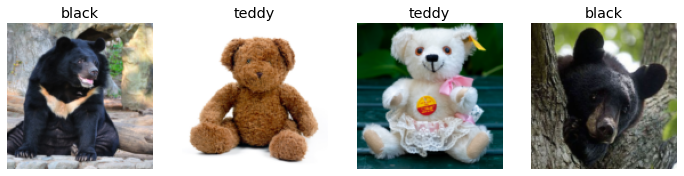

In [14]:
loaders = bears.dataloaders(path)
loaders.valid.show_batch(max_n=4, nrows=1)

## 1.4 Data Transformations
Quite often it is necessary to transform the original images from our dataset to accomodate the expectations of our model. One of those requirements is that images should be of the same size. This is because tensors --the actual inputs to our model-- always have fixed dimensions, so we need to ensure that all our images conform to this:

In [15]:
# Notice how we can clone an existing datablock and override specific pieces
# In this case, we want all images to be resized to 128 pixels, "squishing" the
# images where necessary
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
type(bears)

fastai.data.block.DataBlock

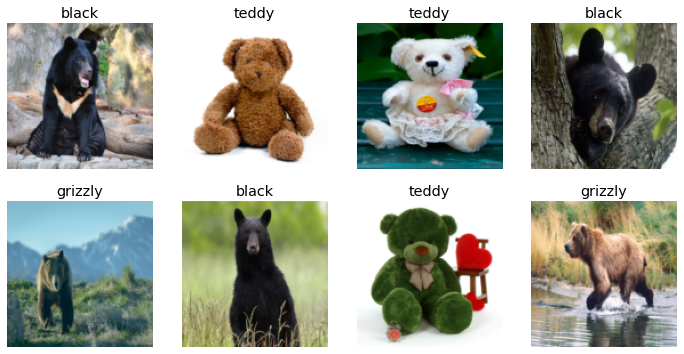

In [16]:
loaders = bears.dataloaders(path)
loaders.valid.show_batch(max_n=8, nrows=2)

Depending on our needs, we may want to do the resizing in different ways, and the `Resize` class supports other modes as well:

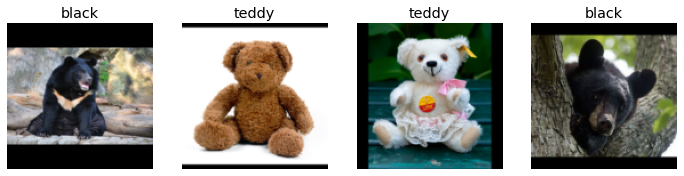

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
loaders = bears.dataloaders(path)
loaders.valid.show_batch(max_n=4, nrows=1)

## 1.5 Data Augmentations
Deep learning models typically require a lot of data to perform well. However, labeled data can be expensive to collect or create, so quite often practioners use what's called **data augmentation** techniques to synthesize new data out of existing data. `fastai` has direct and easy support for this.

### 1.5.1 Avoiding Distortion When Resizing
Sometimes none of the resizing methods mentioned above is a good idea: squishing may distort an object too much, and adding black or white borders can introduce undesired effects in the classification. All of this can confuse our model and reduce its accuracy.

In this case, an alternative strategy is to take several shots of subregions of the original image, effectively turning an image into several ones. The following example demonstrates this:

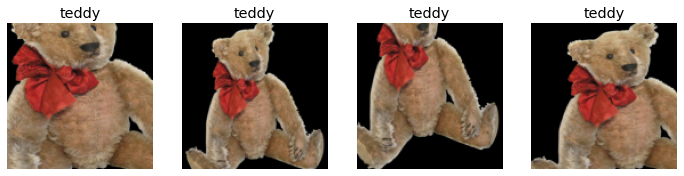

In [18]:
target_size = 128
# `min_scale` represents the minimum proportion of the image that will be used for the
# random crops
bears = bears.new(item_tfms=RandomResizedCrop(target_size, min_scale=0.3))
loaders = bears.dataloaders(path)
loaders.train.show_batch(max_n=4, nrows=1, unique=True)

### 1.5.2 Standard Data Augmentations
`fastai` also provides the `aug_transforms` convenience method which packages a set of data augmentations which have been shown to be useful, including "shearing" operations which are non-linear transformations of the image:

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


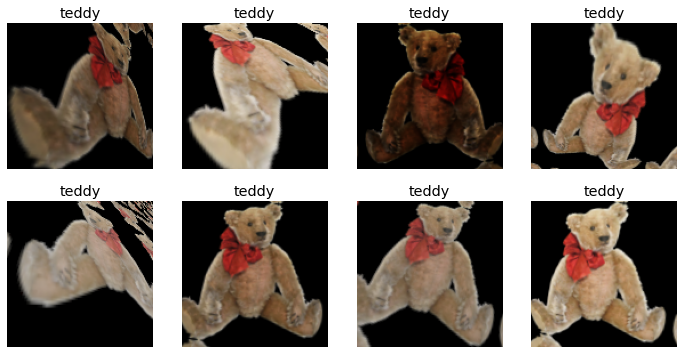

In [19]:
# `mult` specifies how extreme do we want various transformations to be;
# larger numbers imply more extreme transformations (default value is 1.0)
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2.5))
loaders = bears.dataloaders(path)
loaders.train.show_batch(max_n=8, nrows=2, unique=True)

# 1.6 Training the Model

In [20]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    # use a default set of data augmentation transforms
    batch_tfms=aug_transforms()
)
loaders = bears.dataloaders(path)

In [28]:
model = cnn_learner(loaders, resnet34, metrics=accuracy)
model.fine_tune(epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.537105,0.311756,0.883721,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.196881,0.040046,0.988372,00:14
1,0.136605,0.006827,1.000000,00:14
2,0.095024,0.006078,1.000000,00:14
3,0.074789,0.006075,1.000000,00:16


# 1.6 Inspecting the Model

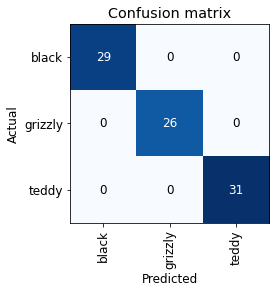

In [29]:
explain = ClassificationInterpretation.from_learner(model)
explain.plot_confusion_matrix()

😀 Our classifier is doing a really good job despite having trained only with a few hundred data points!

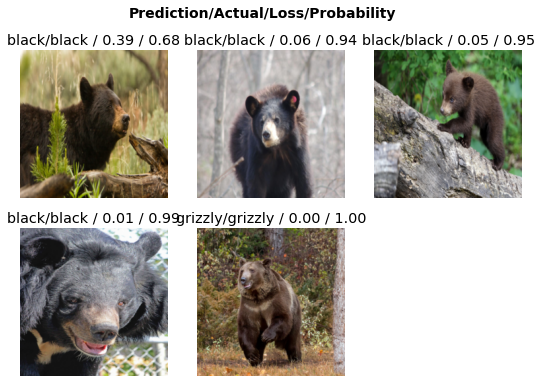

In [30]:
explain.plot_top_losses(5)

## Cleaning up Training/Validation Datasets
`fastai` also makes it easy to clean up our training and validation data. In this case, given the results in the confusion matrix, it seems unlikely that we'll need to clean up anything, but let's have a look at them anyway:

In [31]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(model)
cleaner

In [32]:
for index in cleaner.delete():
    # `fns` is an unfortunate name; it stands for `filenames`
    cleaner.fns[index].unlink()

In [33]:
import uuid

def move_with_autorename(source, destination, *args, follow_symlinks=True):
    source = Path(source)
    if not source.exists():
        print(f'{source} no longer exists; skipping...')
        return
    destination = Path(destination)
    print(f'moving from {source} to {destination}')
    if Path(destination).exists():
        print(f'path {destination/source.name} exists...')
        destination = destination.with_name(uuid.uuid4().hex)
        print(f'... so creating unique filename: {destination}')
    shutil.move(source, destination)

In [34]:
for index, category in cleaner.change():
    move_with_autorename(str(cleaner.fns[index]), path/category)

In [35]:
for index in cleaner.delete():
    cleaner.fns[index].unlink()

For small datasets (such as when we're doing transfer learning), `fastai`s utilities are probably fine. However, if you're having to label or clean up a much larger dataset, there are other suitable solutions for this problem. [Prodigy](https://prodi.gy/) is one of them.

# 1.7 Model Persistence

### Save the Model

In [36]:
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Reload the Model

In [37]:
model_inf = load_learner(path/'export.pkl')
model_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.4912e-07, 9.9999e-01, 6.6019e-06]))

In [38]:
model_inf.dls.vocab

['black', 'grizzly', 'teddy']

# 1.8 A Prototype Application

In [39]:
upload_button = widgets.FileUpload()
upload_button

FileUpload(value={}, description='Upload')

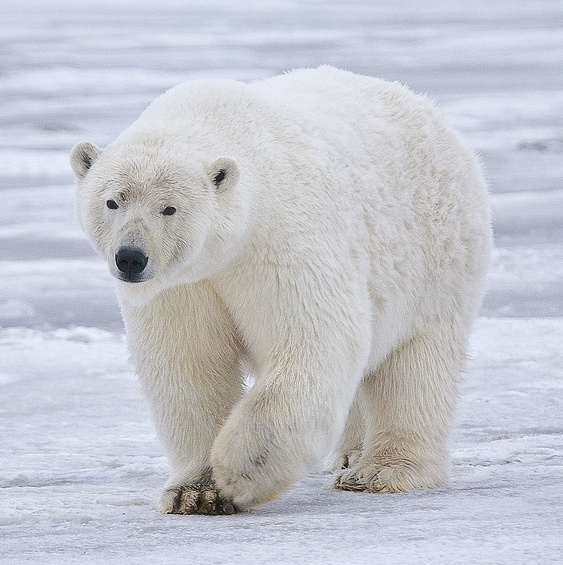

In [41]:
img = PILImage.create(upload_button.data[-1]); img

In [42]:
output = widgets.Output()
output.clear_output()
with output:
    display(img.to_thumb(128, 128))
output

Output()

In [44]:
prediction, prediction_index, probabilities = model_inf.predict(img)

In [47]:
prediction_label = widgets.Label()
prediction_label.value = f'Prediction: {prediction} -- Probability: {probabilities[prediction_index]:.04f}'
prediction_label

Label(value='Prediction: grizzly -- Probability: 0.9491')

## 1.8.1 Putting All Together

In [50]:
run_button = widgets.Button(description='Classify')
run_button

Button(description='Classify', style=ButtonStyle())

In [51]:
def classify_image(change):
    img = PILImage.create(upload_button.data[-1])
    output.clear_output()
    with output:
        display(img.to_thumb(128, 128))
    prediction, prediction_index, probabilities = model_inf.predict(img)
    prediction_label.value = f'Prediction: {prediction} -- Probability: {probabilities[prediction_index]:.04f}'
    
run_button.on_click(classify_image)

In [54]:
VBox([widgets.Label('Select your bear!'), upload_button, run_button, output, prediction_label])

# Questions

**1. Where do text models currently have a major deficiency?**

They may generate text that is coherent, thus fooling you to think that the model has a good underlying semantics model but this is not really the case (particularly for models with not so large training set), as can be easily discovered by asking questions that require more simple information retrieval (e.g., questions that require some level of reasoning)

**2. What are possible negative societal implications of text generation models?**

A very bad potential scenario is the ease with which a bad actor can now create fake news, fake reports, etc., spreading misinformation, instigating conflict in social media, amplifying polarization, etc.

**3. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?**

A man in the loop approach can be very useful. The ideal situation is where the model truly improves the efficiency of the overall system by doing the heavy lifting but letting the human verify and approve or correct the output. When that positive balance is not achieved, the model can be more of a nuisance than a helping hand for humans.

**4. What kind of tabular data is deep learning particularly good at?**

Categorical variables with a large number of values (why?). Also for datasets with columns containing free text, images or other free structure data.

**5. What's a key downside of directly using a deep learning for recommendation systems?**

The fact that recommendations often focus on items or content that is already familiar to the user (e.g., books already bought or known; very similar content on YouTube), to the detriment of the discovery of more diverse, but still related content or items.

**6. What are the steps of the Drivetrain Approach?**

+ **Manual Process**: model and manual process in parallel with human checks.
+ **Limited Scope Deployment**: time/space bound to limit potential fallout, again with careful human supervision
+ **Gradual Expansion**: using monitoring data to detect issues and collect more data, as well as considering potential consequences.

**7. How do the steps of the Drivetrain Approach map to a recommendation system?**

+ **Manual Process**: present the user with both general content and personal recommendations and clearly label them as such. Keep track of which personal recommendations seem to be valuable to the user. Allow the user to select if they wnat to have user recommendations at all.


+ **Limited Scope**: keep the ratioo of the two options at 30/70 initially, but allow the user to tweak it or turn it off completely. The user should be able to provide feedback easily on whether recommendations are any good. This should be user-friendly lest they ignore it and we miss an important signal.


+ **Gradual Expansion**: it's important to track how much value has the user obtained from this new systme in periodic intervals, and always allow the user to turn off the system for comparison. It's also important to always keep the rest of the content by default to avoid echo chambers or reinforcement cycles of negative content bubbles (e.g., biased news in favor of a political party, at the exclusion of news about other parties.) This part is tricky to get right, but we should not neglect it because it can have nefarious consequences.

**9. What is `DataLoaders`?**

It's a utility class that helps to do data preprocessing for deep learning models. It can do things such as split the dataset into training/validation subsets, shuffle the data, apply transformations, do data augmentations, etc., and finally convert the data into tensors.

**10. What things do we need to tell `fastai` to create `DataLoaders`?**

1. A function to tell classes of objects apart (e.g., dogs vs cats) from the input files
2. How to split the data into training and validation sets
3. How to do preprocessing of the data
4. The types of inputs and outputs for the model (e.g., images for the input, categories for the output)
5. How to get the input data from the file system

**11. What does the `splitter` parameter to `DataBlock` do?**

It tells how to split the data into training and validation sets, both the ratio (90:10) and the random seed for shuffling that happens before the split.

**12. How do we ensure a random split always gives the same validation set?**

By passing the same value to the random set.

**13. What letters are often used to signify the independent and dependent variables?**

X and Y

**14. What's the difference between the crop, pad, and squish resize approches? When might you choose one over the others?**

`crop` will lose information by taking a subset of the image and discarding the rest. `pad` will add a lot of unnecessary null pixels on the borders. `squish` will resize the image, but it will not respect the aspect ratio, so it will likely distort it in ways that may affect your model's predictions.

Cropping is actually not such a bad idea, as long as you crop various sections and include them all in your training data. This is presumably how our own vision system processes information all the time.

Squishing may also not be such a bad idea, considering that in the real world our vision system also takes in similarly distorted inputs, but which tend to preserve enough information for successful identity resolution. However, for some problems, squishing could completely lose identity information (e.g., spectrograms or any other visual representation of non-visual data)

Padding might be useful whenever the two approaches above are inadequate or are giving bad results. The downside is wasted computation on the null borders.

**15. What is data augmentation? Why is it needed?**

It's the addition of training data based on existing training data by doing slight modifications to it. For images, this may mean scaling, rotating, dimming or sharpening illumination, adding some Gaussian noise, as well as some other transformations which tend to preserve our ability to do identity resolution.

It is usually needed when there isn't enough training data, or when we want the network to be exposed to more general patterns that might reflect the expected distribution in production.

**16. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.**

Photos of bears in the wild may be in poor lighting, occluded by bushes or other flora, shot from far away, etc. All of these conditions are very different from typical training photos where the bear is clealry visible and with good lighting.

**17. What is the difference between `item_tfms` and `batch_tfms`?**

`item_tfms` stands for "item transformations" and is a sequence of transformations to be applied to each individual image using the CPU (i.e., after they are loaded from disk). `batch_tfms` stands for "batch transformations" and is a sequence of transformations to be applied to a full batch of images all at once in the GPU; this assumes the images have been converted to tensors at this point.

**18. What is a confusion matrix?**

It's a color-coded matrix that presents a model's classification results for every pair of categories, showing in darker colors regions where more mistakes were made. This allows to quickly identify where a model is having trouble classifying instances.

**19. What does `export` save?**

It saves the architecture of the model, the current set of weights, and the transformations applied on the raw data for the validation test (but not for training, so the data augmentation steps are not saved.)

**20. What is called when we use a model for making predictions, instead of training?**

It's usually called the *inference* step

**21. What are IPython widgets?**

They're classes in Python/Javascript to represent and render graphical web widgets, useful to easily create web pages from within Jupyter.

**22. When would you use a CPU for deployment? When might a GPU be better?**

When latency is important and you tend to do inference one instance at a time, using a CPU is preferable. The cost of the servers may also be an important selection criterion, since GPUs are more expensive. GPUs can be useful if you can batch many instances, though.

**23. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?**

+ There could be some latency due to the network roundtrip required
+ There might be some privacy concerns on the user's data leaving a person's network or device

**24. What are three examples of problems that could occur when rolling out a bear warning system in practice?**

It depends on the rolling out strategy. For instance, if the system is deployed without human monitoring, we may be putting many lives at risk whenever we get false negatives.

If the system is deployed with a man in the middle strategy, there is still a risk that if the system has too many false positives, the guards will start dismissing many alerts from the system to the point where they could let an actual bear come inside by accident.

**25. What is out-of-domain data?**

It's data that follows a very differente statistical distribution from what was seen by the model during training.

**26. What is domain shift?**

It's when the data distribution from which the original training data was extracted changes over time, eventually rendering the model useless.

**27. What are the three steps in the deployment process?**

1. Manual Process
2. Limited Scope Deployment
3. Gradual Expansion

# Further Research

**1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.**

One project I'm interested in is the mapping of music files (30 seconds or so) to one or more genres. In this case, I don't necessarily see much of a risk on its deployment as long as it wasn't used to automate anything that humans currently do.

But assuming for a moment that we were to automate new songs classification into genres, I think we should consider the potential problems involved. One such problem could be that may new songs might be misclassified and therefore not promoted properly on platforms such as Spotify or Google Music, potentially causing artists some economic damage.

In this situation, the Drivetrain Approach would be a pretty good idea. Let's see how it would map:

**Manual Process** -- In the beginning, we'd make sure the system is complemented with a human in the loop that can confirm that genres assigned make sense. Depending on the observed precision and recall, we might eventually let it run automatically if the classifier is confident above a certain threshold. To prevent regressions from happening, we'd also have to keep an ever evolving test set that any new model versions would have to pass above a certain threshold (e.g., 90% precision)

**Limited Scope Deployment** -- Since money is potentially at stake here, we might run a limited pilot program with lesser known artists first. Another way to keep a potential bad impact minimal would be to have the system only classify a fraction of all the songs being promoted.

**Gradual Expansion** -- As the system is validated and improved, we might start adding better known artists. I think it'd be quite important at this point to let users know that genre classification is being done by an automatic system, so that they can provide feedback whenever they feel like the classification has been incorrect.

**2. When might it be best to avoid certain types of data augmentation?**

Probably whenever the augmentation changes the identity of the object. For example, if we're classifying symbols, and among them we have "8" and the symbol for infinity, 90-degree rotations would make them indistinguishable, thus confusing the system.

Similarly, a zoom on a person's t-shirt could capture small visual patterns which are irrelevant for classifying an object as a human. To some extent, this already happens in all CNNs, but the augmentation could amplify the problem.